# Deep Learning Project: prediction of malaria

## Imports

In [ ]:
import os
import numpy as np 
import random
import cv2
import glob 
import pandas as pd 
import matplotlib.pyplot as plt
import time
import copy
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import transforms, datasets, models
from torchsummary import summary
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image


In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

1.7.0+cu101
True
True


In [ ]:
os.getcwd()
img_dir ='./malaria'
print(os.listdir(img_dir))

['training', 'validation', 'testing']


## Parameters

In [ ]:
INIT_LR = 1e-3
EPOCHS = 50
MOMENTUM = 0.9
EXPERIMENT_PATH = 'exp_resnet50_1e-3_malaria_3'
data_path = './malaria'

## 0 - Dataset

### Data vizualisation

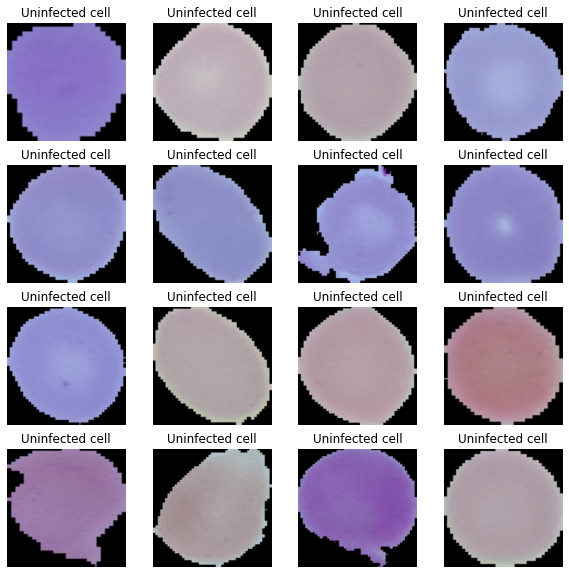

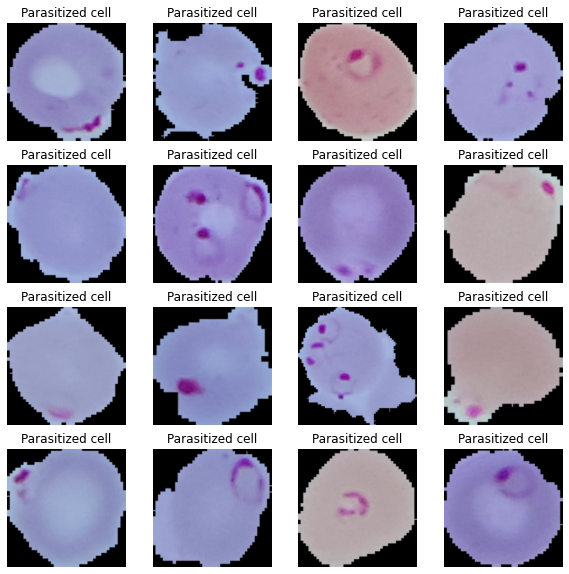

In [ ]:
def plot_sample(im_paths,title):
  """
  plots 16 random images from the selected image paths.
  """
  sample_size = 16
  plt.figure(figsize=(10,10))
  sample = random.sample(glob.glob(im_paths), sample_size)
  i=1
  for im_path in sample:
    im = cv2.imread(im_path)
    im = cv2.resize(im,(224,224))
    plt.subplot(4,4,i)
    plt.imshow(im)
    plt.title(title)
    plt.axis('off')
    i+=1
  plt.show()


plot_sample('./malaria/validation/Uninfected/*.png','Uninfected cell')
plot_sample('./malaria/validation/Parasitized/*.png','Parasitized cell')

### Transforms

In [ ]:
def show_aug(im_path, transforms):
  n_samples = 16
  im = cv2.imread(im_path)
  print(im.shape)
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  PIL_im = Image.fromarray(im)
  fig = plt.figure(figsize=(5,5))
  for i in range(n_samples):
    plt.subplot(4,4,i+1)
    im_aug = transforms(PIL_im)
    plt.imshow(im_aug.permute(1,2,0))
    plt.axis('off')
  plt.show()


transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
augment_transforms = transforms.Compose([transforms.Resize(254),
                                       transforms.CenterCrop(224),
                                       transforms.RandomAffine(degrees=20,translate=(0,0.05),shear=(0,0.05)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


(115, 136, 3)


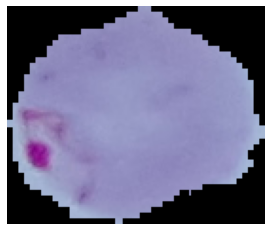

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

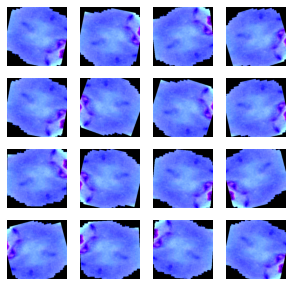

In [ ]:
im_path = glob.glob('./malaria/training/Parasitized/*.png')[6]
show_aug(im_path, augment_transforms)

### Preparing the data

In [ ]:
NUM_WORKERS = 1
BS = 32
AUGMENT = True

if AUGMENT:
  train_transforms = augment_transforms
 
else:
  train_transforms = transform

valid_transforms = transform
test_transforms = transform

# defining loaders with corresponding transformers
train_data = datasets.ImageFolder(data_path + '/training/',transform = train_transforms)
valid_data = datasets.ImageFolder(data_path+'/validation/',transform = valid_transforms)
test_data = datasets.ImageFolder(data_path+ '/testing/',transform = test_transforms)

# prepare data loaders 
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = BS,
                                           shuffle = True,
                                           num_workers = NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size = BS, 
                                           shuffle = False, 
                                           num_workers = NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size = BS,
                                          shuffle = False,
                                          num_workers = NUM_WORKERS)

print('Training dataset size:',len(train_loader.dataset))
print('Validation dataset size:',len(valid_loader.dataset))
print('Testing dataset size:',len(test_loader.dataset))

Training dataset size: 18885
Validation dataset size: 2098
Testing dataset size: 5266


### Checking the size of input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape:  torch.Size([32, 3, 224, 224])
Output label tensors:  tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1])

Output label tensor shape:  torch.Size([32])


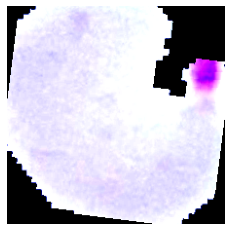

In [ ]:
single_batch = next(iter(train_loader))

print("Batch shape: ",single_batch[0].shape)
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)
# Selecting the first image tensor from the batch. 
im = single_batch[0][0]
im.shape
plt.imshow(im.permute(1, 2, 0))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1809.5, 905.5, -0.5)

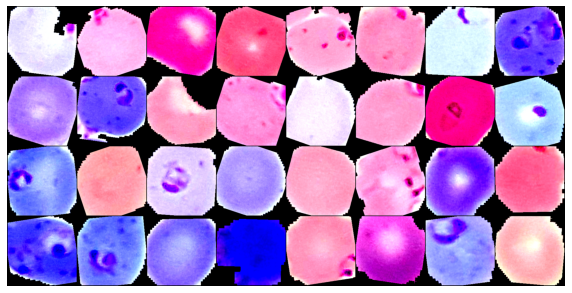

In [ ]:
single_batch_grid = torchvision.utils.make_grid(single_batch[0], nrow=8)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))
plt.axis('off')




## I - Classical models
## Model architectures

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    """
    freezes parameters of the model
    inputs: - model: neural network to train 
            - feature_extracting: boolean to set feature extracting or not
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

      
def ResNet50():
  n_classes = 2
  model_ft = models.resnet50(pretrained = True)
  set_parameter_requires_grad(model_ft ,False)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Sequential(
    nn.Dropout(p = 0.5),
    nn.Linear(num_ftrs,n_classes))
  
  return model_ft

def SqueezeNet():
  n_classes = 2
  model_ft = torch.hub.load('pytorch/vision:v0.6.0', 'squeezenet1_0', pretrained=True)
  set_parameter_requires_grad(model_ft ,False)
  num_ftrs = 512
  model_ft.classifier = nn.Sequential(
    nn.Conv2d(num_ftrs,n_classes,kernel_size=(1, 1), stride=(1, 1)),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1))
  )
  
  return model_ft

def ResNet34():
  n_classes = 2
  model_ft = models.resnet34(pretrained = True)
  set_parameter_requires_grad(model_ft ,False)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Sequential(
      nn.Linear(num_ftrs,n_classes))
    
  return model_ft

def ResNet18():
  n_classes = 2
  model_ft = models.resnet18(pretrained = True)
  set_parameter_requires_grad(model_ft ,False)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Sequential(
      nn.Linear(num_ftrs,n_classes))
    
  return model_ft

def MobileNet():
    """
    returns a MobilNet with an added dropout and fully connected layer on the top 
    input size = 224
    """
    n_classes = 2

    model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
    set_parameter_requires_grad(model,False)
    model.classifier[1] = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(model.last_channel,n_classes))
    return model


## Training

### Plots for visualization

In [ ]:
def plot_acc(H, experiment_path):

  fig = plt.figure(figsize=(5,5))
  plt.plot(H['epoch'],H['train_acc'],H['valid_acc'])
  plt.legend(["Training","Validation"])
  plt.title("Accuracy")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy(%)')
  plt.savefig(experiment_path+ '/fig_acc.png')
  plt.show()

def plot_loss(H, experiment_path):
  fig = plt.figure(figsize=(5,5))
  plt.plot(H['epoch'],H['train_loss'],H['valid_loss'])
  plt.legend(["Training","Validation"])
  plt.title("Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Binary Cross Entropy')
  plt.savefig(experiment_path+ '/fig_loss.png')
  plt.show()

### Train model

In [ ]:
def train_model(n_epochs, model,train_loader,valid_loader, optimizer, criterion, experiment_path ,use_cuda):
   
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    best_valid_acc = 0.
    best_model_wts = copy.deepcopy(model.state_dict())
    # history
    H = []
    since = time.time()
    if not os.path.isdir(experiment_path) :
      os.mkdir(experiment_path)

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss, valid_loss  = 0., 0.
        train_correct, valid_correct = 0., 0.
        model.train()
        for batch_idx, (data, labels) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, labels = data.cuda(), labels.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, labels)
            train_correct += torch.sum(preds == labels.data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
          
        model.eval()
        for batch_idx, (data, labels) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, labels = data.cuda(), labels.cuda()
            output = model(data)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, labels)
            valid_correct += torch.sum(preds == labels.data)
            valid_loss += loss.item() * data.size(0)
        #scheduler.step()

        # track the accuracy
        train_acc = train_correct/len(train_loader.dataset)       
        valid_acc = valid_correct/len(valid_loader.dataset)
        train_loss /= len(train_loader.dataset)  
        valid_loss /= len(valid_loader.dataset) 

        H.append([epoch,train_loss,valid_loss,train_acc.item(),valid_acc.item()])
        # print training/validation statistics 
        print('Epoch: [{}/{}] \tTraining Loss: {:.6f}  \tTraining Acc: {:.6f} \tValidation Loss: {:.6f} \tValidation Acc: {:.6f} '.format(
            epoch,n_epochs, train_loss,train_acc,valid_loss,valid_acc))

        if valid_acc >= best_valid_acc:
          model_file = experiment_path + '/best_model_'+str(np.round(valid_acc.detach().cpu().numpy(),2))+'.pth'
          best_model_wts = copy.deepcopy(model.state_dict())
          torch.save(best_model_wts, experiment_path + '/best_model.pth') 

    torch.save(best_model_wts, model_file) 

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
    history = pd.DataFrame(data = H, columns = ['epoch','train_loss','valid_loss','train_acc','valid_acc'])
    history.to_csv(EXPERIMENT_PATH + '/history.csv')
    plot_acc(history, experiment_path)
    plot_loss(history, experiment_path)
    return model

In [ ]:
model = ResNet50()


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.8739e-03.
Epoch: [1/50] 	Training Loss: 0.129318  	Training Acc: 0.959015 	Validation Loss: 0.089325 	Validation Acc: 0.974738 
Adjusting learning rate of group 0 to 9.7494e-03.
Epoch: [2/50] 	Training Loss: 0.079696  	Training Acc: 0.975324 	Validation Loss: 0.054312 	Validation Acc: 0.984747 
Adjusting learning rate of group 0 to 9.6265e-03.
Epoch: [3/50] 	Training Loss: 0.071885  	Training Acc: 0.977495 	Validation Loss: 0.050236 	Validation Acc: 0.985701 
Adjusting learning rate of group 0 to 9.5051e-03.
Epoch: [4/50] 	Training Loss: 0.065998  	Training Acc: 0.978766 	Validation Loss: 0.042009 	Validation Acc: 0.986654 
Adjusting learning rate of group 0 to 9.3852e-03.
Epoch: [5/50] 	Training Loss: 0.061619  	Training Acc: 0.981202 	Validation Loss: 0.053326 	Validation Acc: 0.983317 
Adjusting learning rate of group 0 to 9.2669e-03.
Epoch: [6/50] 	Training Loss: 0.058239  	Training Acc: 0.982

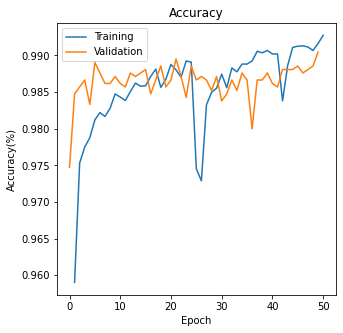

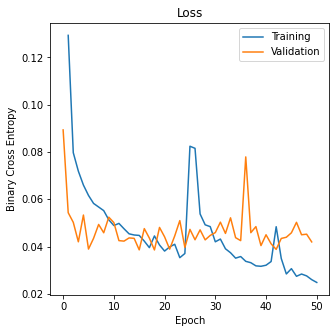

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
EXPERIMENT_PATH = 'exp_ResNet50'

INIT_LR = 1e-2
MOMENTUM = 0.9
EPOCHS = 50

criterion = nn.CrossEntropyLoss()
lmbda = lambda epoch: 0.98739
optimizer = optim.SGD(model.parameters(), lr = INIT_LR, momentum = MOMENTUM, weight_decay = 1e-6 )
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda,verbose = True)

best_model = train_model(EPOCHS, model, train_loader, valid_loader, optimizer, criterion, EXPERIMENT_PATH, use_cuda)

## Evaluation

###  Load best model

In [ ]:
use_cuda = torch.cuda.is_available()
model = ResNet50()
criterion = nn.CrossEntropyLoss()

EXPERIMENT_PATH = 'exp_ResNet50'
model.load_state_dict(torch.load(EXPERIMENT_PATH + '/best_model_0.99.pth'))
model = model.cuda()

### Evaluate model

In [ ]:
def eval_model(model,data_loader):
  correct = 0.
  test_loss = 0
  all_preds = torch.tensor([])
  model.eval()
  with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(data_loader):
        if use_cuda:
            data, labels = data.cuda(), labels.cuda()
        # predictions
        output = model(data)
        _, preds = torch.max(output.data, 1)
        correct += torch.sum(preds == labels.data)
        loss = criterion(output, labels)
        test_loss += loss.item() * data.size(0)
  test_loss /= len(data_loader.dataset) 

  return correct/len(data_loader.dataset), test_loss

        
def get_predictions(model, data_loader, use_cuda):
  """
  returns predictions of the images in the data loader 
  """
  all_targets = torch.tensor([])
  all_preds = torch.tensor([])
  model.eval()
  with torch.no_grad():
    
    for batch_idx, (data, targets) in enumerate(data_loader):
      if use_cuda :
        all_targets, all_preds = all_targets.cuda(), all_preds.cuda()
        data, targets = data.cuda(), targets.cuda()
      # predictions
      output = model(data)
      _, preds = torch.max(output.data, 1)

      all_preds = torch.cat(
          (all_preds, preds),dim=0)
      all_targets = torch.cat(
          (all_targets, targets),dim=0)
  return all_preds.detach().cpu().numpy(), all_targets.detach().cpu().numpy()

### Confusion matrix and metrics

In [ ]:
# evaluate model
acc, loss = eval_model(model,test_loader)
print('test accuracy : ',acc)
print('test loss : ',loss)

 
# get predictions
preds, targets = get_predictions(model, test_loader, use_cuda = True)

# confusion matrix
cm = pd.DataFrame(confusion_matrix(targets, preds))
cm.to_csv(EXPERIMENT_PATH +'/confusion_matrix.csv')
print(cm)

# classification report 
cr = classification_report(targets,preds, digits = 3)
f = open(EXPERIMENT_PATH + '/class_report.txt', "a")
f.write(cr)
f.close()
print(cr)


test accuracy :  tensor(0.9877, device='cuda:0')
test loss :  0.03936418405997965
      0     1
0  2675    44
1    21  2526
              precision    recall  f1-score   support

         0.0      0.992     0.984     0.988      2719
         1.0      0.983     0.992     0.987      2547

    accuracy                          0.988      5266
   macro avg      0.988     0.988     0.988      5266
weighted avg      0.988     0.988     0.988      5266



In [ ]:
predictions = pd.DataFrame(data = np.array([targets,preds]).T, columns = ['target','pred'])
predictions.to_csv(EXPERIMENT_PATH + '/predictions.csv')


## II - Autoencoder NN



### Data preparation

In [ ]:
transform = transforms.Compose([transforms.Resize(34),
                                      transforms.CenterCrop(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
augment_transforms = transforms.Compose([transforms.Resize(34),
                                       transforms.CenterCrop(32),
                                       transforms.RandomAffine(degrees=20,translate=(0,0.05),shear=(0,0.05)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
NUM_WORKERS = 4
BS = 32
AUGMENT = True

if AUGMENT:
  train_transforms = augment_transforms
 
else:
  train_transforms = transform

valid_transforms = transform
test_transforms = transform

# defining loaders with corresponding transformers
train_data = datasets.ImageFolder('./malaria/training/',transform = train_transforms)
valid_data = datasets.ImageFolder('./malaria/validation/',transform = valid_transforms)
test_data = datasets.ImageFolder('./malaria/testing/',transform = test_transforms)

# prepare data loaders 
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = BS,
                                           shuffle = True,
                                           num_workers = NUM_WORKERS)


In [ ]:
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size = BS, 
                                           shuffle = False, 
                                           num_workers = NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size = BS,
                                          shuffle = False,
                                          num_workers = 1)
print('Training dataset size:',len(train_loader.dataset))
print('Validation dataset size:',len(valid_loader.dataset))
print('Testing dataset size:',len(test_loader.dataset))


Training dataset size: 9496
Validation dataset size: 2098
Testing dataset size: 5266


### Autoencoder architecture 

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # input channel : 3, output channels : 16, kernel size : 3x3
        # nn.ZeroPad2d((1, 1, 1, 1))
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 4, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 4, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Upsample(scale_factor = (2,2)),
            nn.ConvTranspose2d(4, 8, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Upsample(scale_factor = (2,2)),
            nn.ConvTranspose2d(8, 16, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Upsample(scale_factor= (2,2)),
            nn.ConvTranspose2d(16, 3, 3, stride = 1,padding = 1)   
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### Training autoencoder

In [ ]:
def train_model_auto(n_epochs, model,train_loader,valid_loader, optimizer, criterion, experiment_path ,use_cuda):
   
    # initialize tracker for minimum validation loss
    best_valid_loss = np.Inf
    best_model_wts = copy.deepcopy(model.state_dict())
    if not os.path.isdir(experiment_path) :
      os.mkdir(experiment_path)
    # history
    H = []
    since = time.time()

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss, valid_loss  = 0., 0.
        model.train()
        for batch_idx, (data, labels) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, labels = data.cuda(), labels.cuda()
            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output.data, 1)            
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
          
        model.eval()
        for batch_idx, (data, labels) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, labels = data.cuda(), labels.cuda()
            output = model(data)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, data)
            valid_loss += loss.item() * data.size(0)

        train_loss /= len(train_loader.dataset)  
        valid_loss /= len(valid_loader.dataset) 
        H.append([epoch,train_loss,valid_loss])
        # print training/validation statistics 
        print('Epoch: [{}/{}] \tTraining Loss: {:.6f}  \tValidation Loss: {:.6f} '.format(
            epoch,n_epochs, train_loss,valid_loss))
        if valid_loss <= best_valid_loss:
          model_file = experiment_path + '/best_model_'+str(np.round(valid_loss,2))+'.pth'
          best_model_wts = copy.deepcopy(model.state_dict())
          torch.save(best_model_wts, experiment_path + '/best_model.pth') 

    torch.save(best_model_wts, model_file) 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  
    H = pd.DataFrame(data = H, columns = ['epoch','train_loss','valid_loss'])
    H.to_csv(EXPERIMENT_PATH + '/history.csv')
    plot_loss(H, experiment_path)

    return model

In [ ]:
model = AutoEncoder()
EXPERIMENT_PATH = 'exp_autoenc1'
#model.load_state_dict(torch.load(EXPERIMENT_PATH + '/best_model_0.12.pth'))
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

# Training parameters
INIT_LR = 0.001
EPOCHS = 200
EXPERIMENT_PATH = 'exp_autoenc2'

criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr = INIT_LR)
best_model = train_model_auto(EPOCHS, model, train_loader, valid_loader, optimizer, criterion, EXPERIMENT_PATH, use_cuda)


### Evaluation

In [ ]:
def get_predictions_auto(model, data_loader, use_cuda):
  """
  returns predictions of the images in the data loader 
  """
  test_loss = 0.
  all_targets = torch.tensor([])
  all_preds = torch.tensor([])
  model.eval()
  with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(data_loader):
      if use_cuda :
        all_targets, all_preds = all_targets.cuda(), all_preds.cuda()
        data, targets = data.cuda(), targets.cuda()
      # predictions
      output = model(data)
      loss = criterion(output, data)
      test_loss += loss.item() * data.size(0)
      test_loss /= len(data_loader.dataset) 

      all_preds = torch.cat(
          (all_preds, output),dim=0)
      all_targets = torch.cat(
          (all_targets, data),dim=0)
  print('Test Loss:', test_loss)
  return all_preds.detach().cpu(), all_targets.detach().cpu()


#### Loading best autoencoder model


In [ ]:
model = AutoEncoder()
EXPERIMENT_PATH = 'exp_autoenc2'

model.load_state_dict(torch.load(EXPERIMENT_PATH + '/best_model_0.07.pth'))
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

In [ ]:
summary(model.cuda(),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4            [-1, 8, 16, 16]           1,160
              ReLU-5            [-1, 8, 16, 16]               0
         MaxPool2d-6              [-1, 8, 8, 8]               0
            Conv2d-7              [-1, 4, 8, 8]             292
              ReLU-8              [-1, 4, 8, 8]               0
         MaxPool2d-9              [-1, 4, 4, 4]               0
  ConvTranspose2d-10              [-1, 4, 4, 4]             148
             ReLU-11              [-1, 4, 4, 4]               0
         Upsample-12              [-1, 4, 8, 8]               0
  ConvTranspose2d-13              [-1, 8, 8, 8]             296
             ReLU-14              [-1, 

#### Getting a few predictions and output images

In [ ]:
preds, targets = get_predictions_auto(model, test_loader, use_cuda)

Test Loss: 0.00024315926812026092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


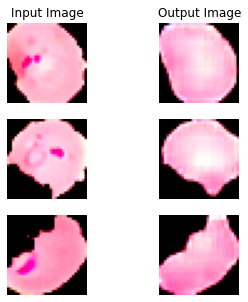

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_autoencoder_results(preds, targets):
  sample_size = 3
  plt.figure(figsize=(5,5))
  i = 1
  while i < 6:
    pred = preds[i].permute(2,1,0)
    target = targets[i].permute(2,1,0)
    plt.subplot(3,2,i)
    plt.imshow(target)
    if i ==1 :
      plt.title('Input Image')
    plt.axis('off')
    plt.subplot(3,2,i + 1)
    if i ==1 :
      plt.title('Output Image')
    plt.imshow(pred)
    plt.axis('off')
    i+=2
  plt.savefig(EXPERIMENT_PATH + '/input_output.png')
  fig = plt.figure()
  plt.show()

plot_autoencoder_results(preds, targets)

## III - Train final classifier

### Architecture of classifier using autoencoder

In [ ]:
def MalariaNet():
  model = AutoEncoder()
  model.load_state_dict(torch.load('./exp_autoenc2/best_model_0.07.pth'))
  model_base = model.encoder
  model_top = nn.Sequential(
      nn.Flatten(),
      nn.Linear(4*4*4,128),
      nn.Linear(128,16),
      nn.Linear(16,2),
    )
  for param in model_base.parameters():
      param.requires_grad = False

  return nn.Sequential(model_base, model_top)



### Training

In [ ]:
model_class = MalariaNet()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4            [-1, 8, 16, 16]           1,160
              ReLU-5            [-1, 8, 16, 16]               0
         MaxPool2d-6              [-1, 8, 8, 8]               0
            Conv2d-7              [-1, 4, 8, 8]             292
              ReLU-8              [-1, 4, 8, 8]               0
         MaxPool2d-9              [-1, 4, 4, 4]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                   [-1, 32]           2,080
           Linear-12                   [-1, 16]             528
           Linear-13                    [-1, 2]              34
Total params: 4,542
Trainable params: 4

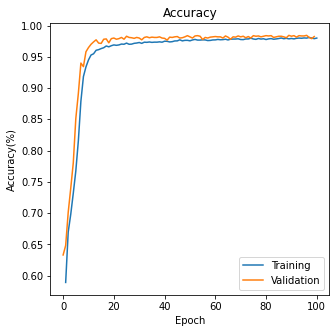

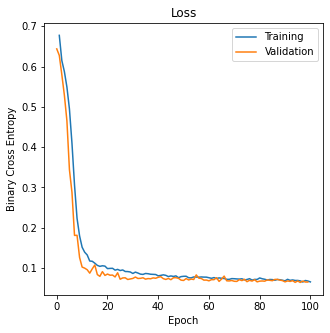

In [ ]:
EXPERIMENT_PATH = 'malaria_classifier'
EPOCHS = 100
INIT_LR = 0.001
MOMENTUM = 0.9

model_class = MalariaNet2()
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_class = model_class.cuda()

summary(model_class.cuda(),(3,32,32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_class.parameters(), lr = INIT_LR, momentum= MOMENTUM)
best_model = train_model(EPOCHS, model_class, train_loader, valid_loader, optimizer, criterion, EXPERIMENT_PATH, use_cuda)


### Evaluation

#### Loading best model

In [ ]:
EXPERIMENT_PATH = 'malaria_classifier'

model = MalariaNet()
model.load_state_dict(torch.load('./malaria_classifier/best_model_0.98.pth'))
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

#### Confusion matrix and metrics

In [ ]:
# evaluate model
criterion = nn.CrossEntropyLoss()

acc = eval_model(model,test_loader)
print('test accuracy : ',acc)
 
# get predictions
preds, targets = get_predictions(model, test_loader, use_cuda = True)

# confusion matrix
cm = pd.DataFrame(confusion_matrix(targets, preds))
cm.to_csv(EXPERIMENT_PATH +'/confusion_matrix.csv')
print(cm)

# classification report 
cr = classification_report(targets,preds, digits = 3)
f = open(EXPERIMENT_PATH + '/confusion_matrix.txt', "a")
f.write(cr)
f.close()
print(cr)


test accuracy :  (tensor(0.9793, device='cuda:0'), 0.06830469346018878)
      0     1
0  2639    80
1    29  2518
              precision    recall  f1-score   support

         0.0      0.989     0.971     0.980      2719
         1.0      0.969     0.989     0.979      2547

    accuracy                          0.979      5266
   macro avg      0.979     0.980     0.979      5266
weighted avg      0.979     0.979     0.979      5266



In [ ]:
filenames = np.array([ elmnts[0] for elmnts in test_loader.dataset.samples])
df = pd.DataFrame(list(zip(filenames, preds, targets)), columns = ['img_dir','pred','target'])

df.to_csv(EXPERIMENT_PATH + '/test_predicitons.csv')

NameError: ignored

In [ ]:
df = pd.read_csv(EXPERIMENT_PATH + '/test_predicitons.csv')
df.head()

,Unnamed: 0,img_dir,pred,target
0,0,./malaria/testing/Parasitized/C100P61ThinF_IMG...,0.0,0.0
1,1,./malaria/testing/Parasitized/C100P61ThinF_IMG...,0.0,0.0
2,2,./malaria/testing/Parasitized/C100P61ThinF_IMG...,0.0,0.0
3,3,./malaria/testing/Parasitized/C100P61ThinF_IMG...,0.0,0.0
4,4,./malaria/testing/Parasitized/C100P61ThinF_IMG...,0.0,0.0


### Predict

In [ ]:
def load_input_image(img_path,transform):    
    prediction_transform = transform = transforms.Compose([transforms.Resize(34),
                                      transforms.CenterCrop(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    img = Image.open(img_path).convert('RGB')
    if transform:
        img = transform(img)
    img = img.unsqueeze(0)
    return img

def predict_malaria(img_path,model, transform, class_names, plot = False):
    # load the image and return the predicted breed
    img = load_input_image(img_path, transform)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    if plot:
      plt.imshow(img[0].permute(2,1,0))
      plt.axis('off')
      plt.title(class_names[idx])
      plt.show()
    return class_names[idx]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


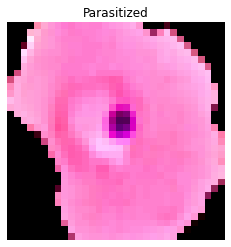

'Parasitized'

In [ ]:
img = glob.glob('./malaria/testing/Parasitized/*.png')[3]
class_names = ['Parasitized','Uninfected']
predict_malaria(img,model, transforms, class_names, True )

### Plotting activation maps 

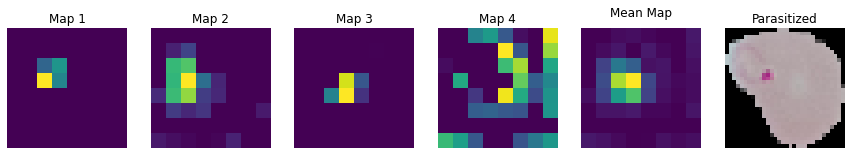

In [ ]:
img_path = glob.glob('./malaria/testing/Parasitized/*.png')[18]
act_path = EXPERIMENT_PATH + '/plots/activations6.jpg'
map_path = EXPERIMENT_PATH + '/plots/map6.jpg'
heatmap_path = EXPERIMENT_PATH + '/plots/heatmap6.jpg'
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

img = cv2.imread(img_path)
img = cv2.resize(img, (32,32))


data = load_input_image(img_path,transforms)
model[0][7].register_forward_hook(get_activation('Conv2d'))
output = model(data)

output = model(data)
act = activation['Conv2d'].squeeze()
fig, ax = plt.subplots(nrows=1, ncols = act.size(0)+2, figsize = (15,15))

heatmap = torch.mean(act, dim=0).squeeze()
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

for idx in range(act.size(0)):
    ax[idx].imshow(act[idx])
    ax[idx].axis('off')
    ax[idx].set_title('Map '+str(idx+1))
ax[4].matshow(heatmap.squeeze())
ax[4].axis('off')
ax[4].set_title('Mean Map')
ax[5].imshow(img)
ax[5].axis('off')
ax[5].set_title('Parasitized')

if not os.path.isdir(EXPERIMENT_PATH + '/plots') :
      os.mkdir(EXPERIMENT_PATH + '/plots')
plt.savefig(act_path)


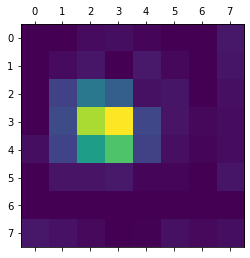

In [ ]:
heatmap = torch.mean(act, dim=0).squeeze()
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())
plt.show()

### Plotting heatmap superposed on original image

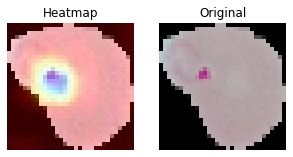

In [ ]:
img = cv2.imread(img_path)
img = cv2.resize(img, (32,32))
heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap*0.4 + img
cv2.imwrite(map_path, superimposed_img)
cam = cv2.imread(map_path)

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (5,5))
ax[0].imshow(cam)
ax[0].axis('off')
ax[0].set_title('Heatmap')
ax[1].imshow(img)
ax[1].axis('off')
ax[1].set_title('Original')

plt.savefig(heatmap_path)

In [ ]:
def get_heatmap(img_path, model, transforms, save_path):

  def get_activation(name):
      def hook(model, input, output):
          activation[name] = output.detach()
      return hook

  data = load_input_image(img_path,transforms)
  model[0][7].register_forward_hook(get_activation('Conv2d'))
  output = model(data)

  output = model(data)
  act = activation['Conv2d'].squeeze()
  heatmap = torch.mean(act, dim=0).squeeze()
  heatmap = np.maximum(heatmap, 0)

  # normalize the heatmap
  heatmap /= torch.max(heatmap)
  img = cv2.imread(img_path)
  img = cv2.resize(img, (32,32))
  heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap*0.4 + img
  cv2.imwrite(save_path, superimposed_img)
  cam = cv2.imread(save_path)
  return img,cam 


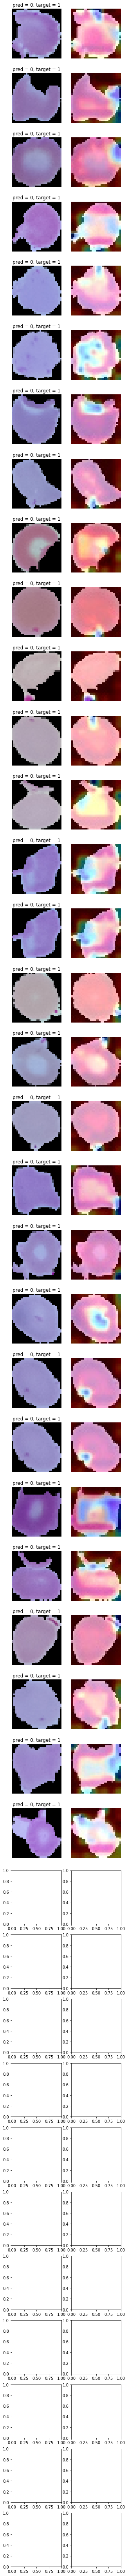

In [ ]:
df = pd.read_csv(EXPERIMENT_PATH + '/test_predicitons.csv')\
  .query('target != pred & pred == 0')

if not os.path.isdir(EXPERIMENT_PATH + '/plots/misclassified_heatmaps') :
      os.mkdir(EXPERIMENT_PATH + '/plots/misclassified_heatmaps')

n = 40
fig,ax = plt.subplots(ncols = 2,nrows = n, figsize = (5,n*3))
i = 0


for img_path in df['img_dir'].values[:n]:


  save_path = EXPERIMENT_PATH + '/plots/misclassified_heatmaps/map_' + str(i)+'.jpg'
  img, heatmap = get_heatmap(img_path, model, transforms, save_path)
  ax[i,0].imshow(img)
  ax[i,0].set_title('pred = 0, target = 1')
  ax[i,1].imshow(heatmap)
  ax[i,0].axis('off')
  ax[i,1].axis('off')

  i += 1
plt.show()
#fig.savefig(EXPERIMENT_PATH+'/plots/heatmaps_pos_neg.jpg')

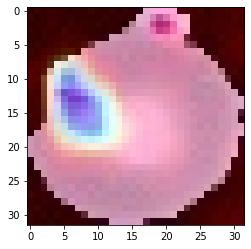